---
layout: post
title: "시계열 데이터 - LSTM"
author: "Chanjun Kim"
categories: Data분석
tags: [Data, TimeSeries, ARIMA, LSTM, BOOSTING, REGRESSION, 시계열데이터, 시계열분석]
image: 05_timeseries.png
---

## **학습목적**
시계열 데이터를 다루는 법과 시계열 예측을 하기 위한 여러가지 모델을 사용해보고 특성을 이해한다.<br>
이 포스팅에선 시계열 데이터의 대표적인 딥러닝 기법인 LSTM에 대해서 설명한다.
> 이 글은 LSTM에 대한 글이므로 EDA에 대한 글은 따로 포스팅하겠습니다.

In [1]:
import os
import sys
import warnings
from tqdm import tqdm

import itertools
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

import scipy
import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, RNN, Reshape
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
mpl.rcParams['axes.unicode_minus'] = False
# fm._rebuild()
plt.rcParams["font.family"] = 'NanumMyeongjo'
plt.rcParams["figure.figsize"] = (10,10)

In [4]:
train = pd.read_csv("data/dacon/energy/train.csv", encoding = "cp949")
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [6]:
test = pd.read_csv("data/dacon/energy/test.csv", encoding = "cp949")
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [8]:
print(train.num.nunique())
print(test.num.nunique())
print(pd.concat([train.num.value_counts().sort_index(), test.num.value_counts()], axis = 1).head())

60
60
    num  num
1  2040  168
2  2040  168
3  2040  168
4  2040  168
5  2040  168


In [9]:
y_col = "전력사용량(kWh)"
length = 24

In [10]:
oh_encoder = OneHotEncoder()

In [38]:
val = train[train.date_time >= "2020-08-15"]
train = train[train.date_time < "2020-08-15"]

In [42]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122155,60,2020-08-14 19,3938.976,25.7,3.1,89.0,0.0,0.0,1.0,1.0
122156,60,2020-08-14 20,3851.712,25.3,2.6,91.0,0.0,0.0,1.0,1.0
122157,60,2020-08-14 21,3368.304,25.6,2.4,91.0,0.0,0.0,1.0,1.0
122158,60,2020-08-14 22,3377.808,25.5,1.8,91.0,0.0,0.0,1.0,1.0


In [67]:
tf_train = pd.concat([
    train["num"].reset_index(drop = True),
    pd.DataFrame(oh_encoder.fit_transform(train[["num"]]).toarray()).add_prefix("num"), 
    train[[y_col]].reset_index(drop = True)], 
    axis = 1)

In [80]:
tf_val = pd.concat([
    val["num"].reset_index(drop = True),
    pd.DataFrame(oh_encoder.transform(val[["num"]]).toarray()).add_prefix("num"), 
    val[y_col].reset_index(drop = True)], 
    axis = 1)

In [76]:
minmax_value = tf_train.groupby("num").agg({y_col : [max, min]}).reset_index().droplevel(axis = 1, level = 0)
minmax_value.columns = ["num", "max", "min"]

In [77]:
tf_train[y_col] = tf_train.groupby("num").apply(lambda x : (x[y_col]-min(x[y_col]))/(max(x[y_col])-min(x[y_col]))).values

In [81]:
tf_val = pd.merge(tf_val, minmax_value, on = "num")
tf_val[y_col]  = tf_val.apply(lambda x : (x[y_col] - x["min"]) / (x["max"] - x["min"]), axis = 1)
tf_val.drop(columns = ["max", "min"], inplace = True)

In [83]:
for i, x in tqdm(enumerate(train.num.unique())):
    X = tf_train.loc[tf_train.num == x].iloc[ : , 1:].reset_index(drop = True)
    Y = tf_train.loc[tf_train.num == x][[y_col]].reset_index(drop = True)
    data = np.array(X)
    targets = np.array(Y)
    data_gen = TimeseriesGenerator(data, targets, length=length, batch_size = len(X) - length)
    
    if i == 0 :
        Xs = data_gen[0][0]
        Ys = data_gen[0][1]
    else :
        Xs = np.concatenate((Xs, data_gen[0][0]))
        Ys = np.concatenate((Ys, data_gen[0][1]))

60it [00:14,  4.24it/s]


In [85]:
for i, x in tqdm(enumerate(train.num.unique())):
    X = tf_train.loc[tf_train.num == x].iloc[ : , 1:].reset_index(drop = True)
    Y = tf_train.loc[tf_train.num == x][[y_col]].reset_index(drop = True)
    data = np.array(X)
    targets = np.array(Y)
    data_gen = TimeseriesGenerator(data, targets, length=length, batch_size = len(X) - length)
    
    if i == 0 :
        val_Xs = data_gen[0][0]
        val_Ys = data_gen[0][1]
    else :
        val_Xs = np.concatenate((val_Xs, data_gen[0][0]))
        val_Ys = np.concatenate((val_Ys, data_gen[0][1]))

60it [00:13,  4.31it/s]


In [86]:
lstm_units=32
dropout=0.2
EPOCH=30
BATCH_SIZE=128

In [87]:
model=Sequential([
    LSTM(lstm_units, return_sequences=False, recurrent_dropout=dropout),
    Dense(1, kernel_initializer=tf.initializers.zeros())
])

In [88]:
model.compile(optimizer='adam', loss='mae', metrics=['mse'])
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다

In [89]:
#가장 좋은 성능을 낸 val_loss가 적은 model만 남겨 놓았습니다.
save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="lstm_model.h5", monitor='val_loss', save_best_only=True)

In [90]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [91]:
print(Xs.shape)
print(Ys.shape)

(106560, 24, 61)
(106560, 1)


In [92]:
print(val_Xs.shape)
print(val_Ys.shape)

(106560, 24, 61)
(106560, 1)


In [93]:
%%time
history = model.fit(Xs, Ys, validation_data = (val_Xs, val_Ys), epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1,
          callbacks=[early_stop, save_best_only])

Epoch 1/30
833/833 [==============================] - 19s 20ms/step - loss: 0.0945 - mse: 0.0228 - accuracy: 9.5721e-04 - val_loss: 0.0453 - val_mse: 0.0056 - val_accuracy: 0.0010
Epoch 2/30
833/833 [==============================] - 16s 19ms/step - loss: 0.0470 - mse: 0.0055 - accuracy: 0.0010 - val_loss: 0.0396 - val_mse: 0.0045 - val_accuracy: 0.0010
Epoch 3/30
833/833 [==============================] - 16s 19ms/step - loss: 0.0420 - mse: 0.0048 - accuracy: 0.0010 - val_loss: 0.0379 - val_mse: 0.0042 - val_accuracy: 0.0010
Epoch 4/30
833/833 [==============================] - 16s 19ms/step - loss: 0.0398 - mse: 0.0044 - accuracy: 0.0010 - val_loss: 0.0364 - val_mse: 0.0039 - val_accuracy: 0.0010
Epoch 5/30
833/833 [==============================] - 16s 19ms/step - loss: 0.0386 - mse: 0.0041 - accuracy: 0.0010 - val_loss: 0.0360 - val_mse: 0.0038 - val_accuracy: 0.0010
Epoch 6/30
833/833 [==============================] - 16s 19ms/step - loss: 0.0372 - mse: 0.0039 - accuracy: 0.0010 

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                12032     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,065
Trainable params: 12,065
Non-trainable params: 0
_________________________________________________________________


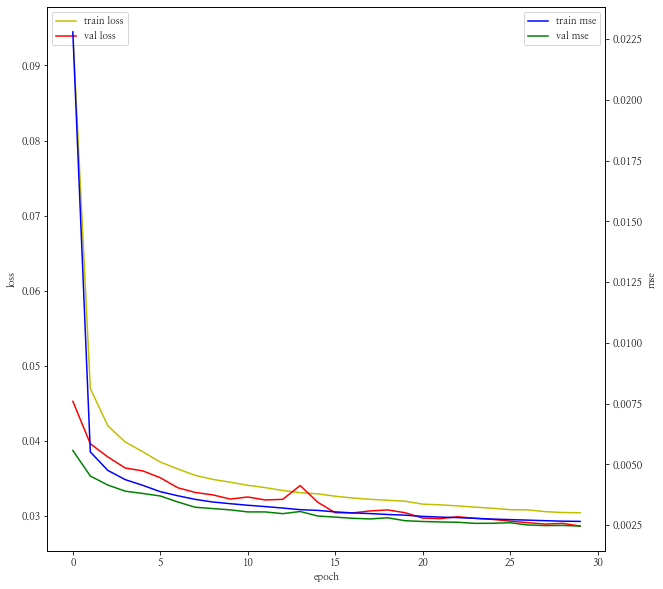

In [102]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['mse'], 'b', label='train mse')
acc_ax.plot(history.history['val_mse'], 'g', label='val mse')
acc_ax.set_ylabel('mse')
acc_ax.legend(loc='upper right')

plt.show()

In [104]:
test[y_col] = pd.NA

In [105]:
predict_epch30 = test[["num", y_col]]

In [ ]:
%%time

result = np.zeros(len(test))
result_idx = 0

for i in tqdm(test.num.unique()):
    for n, m in enumerate(range(len(tf_val[tf_val.num == i]))) :
        if n == 0 :
            predict_data = np.array(tf_train.loc[tf_train.num == x].iloc[-24: , 1:])
        else : 
            predict_data = predict_data[-24:]
        next_= model.predict(np.reshape(predict_data, (1, Xs.shape[1], Xs.shape[2])))
        onehot_value = tf_train.loc[tf_train.num == x].iloc[-1: , 1:-1]
        predict_data = np.concatenate([predict_data, np.array([list(onehot_value.values[0]) + [next_[0][0]]])])
        result[result_idx] = next_
        result_idx += 1

 57%|████████████████████████████▉                      | 34/60 [05:29<04:02,  9.34s/it]

In [156]:
predict_epch30[y_col] = result
predict_epch30

,num,전력사용량(kWh)
0,1,0.519483
1,1,0.501995
2,1,0.497243
3,1,0.500846
4,1,0.511387
...,...,...
10075,60,0.686439
10076,60,0.660960
10077,60,0.609742
10078,60,0.539052


In [179]:
val_result = pd.concat([tf_val[y_col], pd.Series([x[0] for x in val_Ys])], axis = 1).reset_index(drop= True).rename(columns = {0 : "predict"})

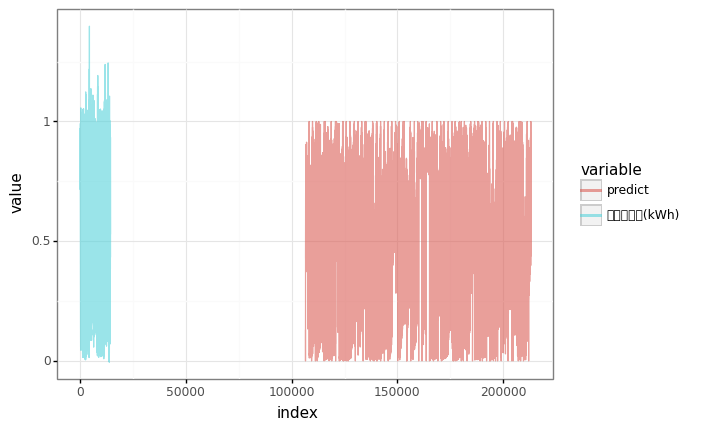

<ggplot: (186453789684)>

In [180]:
(
    p9.ggplot() +
    p9.geom_line(data = val_result.melt().reset_index(), 
                 mapping = p9.aes(x = "index", y = "value", color = "variable", group = "variable"), alpha = 0.6) +
    p9.theme_bw()
)

---

참고 자료 : 
- https://dacon.io/competitions/official/235736/codeshare/2628?page=1&dtype=recent
- https://byeongkijeong.github.io/ARIMA-with-Python/
- https://otexts.com/fppkr/arima-estimation.html